## CS4243, CW4, Deep Image Classification, Q5
### 2022, Amir

In [1]:
''' 
To run this code on co lab: 

add: import os

add: 
from google.colab import drive
drive.mount('/content/gdrive')
!ls

set the directory, e.g.:
"/content/gdrive/MyDrive/ANN/pets_very_small"
"/content/gdrive/MyDrive/ANN/flst.txt"

flst.txt file should be modified too

'''

' \nTo run this code on co lab: \n\nadd: import os\n\nadd: \nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\')\n!ls\n\nset the directory, e.g.:\n"/content/gdrive/MyDrive/ANN/pets_very_small"\n"/content/gdrive/MyDrive/ANN/flst.txt"\n\nflst.txt file should be modified too\n\n'

In [2]:
# we just need these packages

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [4]:
# to check if we have got GPU or not

In [5]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0Metal device set to: Apple M1 Pro


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-31 10:03:09.339210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 10:03:09.339351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-31 10:03:09.340281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 10:03:09.340297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# setting the train and evaluation dataset and directories
# train/evaluation directory is pets_very_small 
#

In [7]:
image_size = (256,256)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cs4243_cw4_images/pets_very_small",
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cs4243_cw4_images/pets_very_small",
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1042 files belonging to 2 classes.
Using 834 files for training.
Found 1042 files belonging to 2 classes.
Using 208 files for validation.


2022-10-31 10:03:09.447188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 10:03:09.447228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-10-31 10:03:09.899499: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


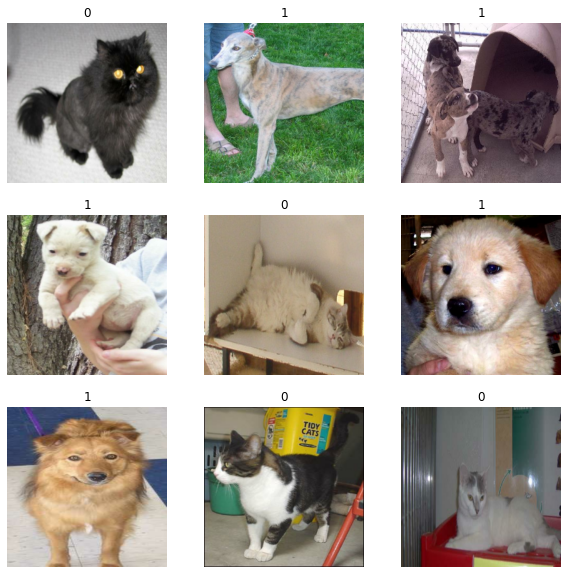

In [8]:
# showing the images 
# 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

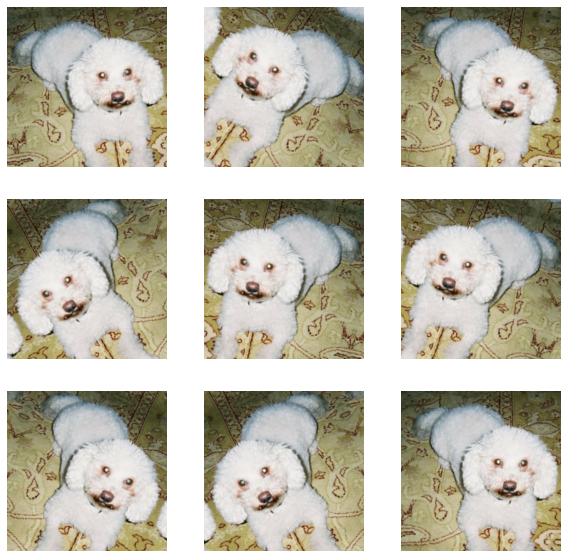

In [9]:
with tf.device('/cpu:0'):
    # data augmentation, using horizontal flip, and random rotation 
    # rotation factor is between 0 to 0.1*2pi 
    # 
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )


    # showing the rotated and flipped images that were added to the 
    # original dataset
    #
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [10]:
# setting train and validation datasets via augmentation

In [11]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
train_ds = train_ds.prefetch(buffer_size=16)
val_ds = val_ds.prefetch(buffer_size=16)

In [13]:
# making our deep model: make_model function
# basically, it is a deep convolutional netwrok. Structure is very similar with VGG16 and 19
#

In [14]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
   
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [15]:
model = make_model(input_shape=image_size + (3,) )


In [16]:
# compiling and training our model

In [17]:
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [18]:
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/10


2022-10-31 10:03:12.771255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.5252

2022-10-31 10:03:31.341727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 21s 352ms/step - loss: 0.7381 - accuracy: 0.5252 - val_loss: 0.6971 - val_accuracy: 0.5048
Epoch 2/10
53/53 [==============================] - 18s 339ms/step - loss: 0.6878 - accuracy: 0.5839 - val_loss: 0.7034 - val_accuracy: 0.5048
Epoch 3/10
53/53 [==============================] - 18s 334ms/step - loss: 0.6570 - accuracy: 0.6067 - val_loss: 0.7916 - val_accuracy: 0.5048
Epoch 4/10
53/53 [==============================] - 18s 339ms/step - loss: 0.6560 - accuracy: 0.6247 - val_loss: 0.7826 - val_accuracy: 0.5048
Epoch 5/10
53/53 [==============================] - 18s 338ms/step - loss: 0.6525 - accuracy: 0.6367 - val_loss: 0.8025 - val_accuracy: 0.5048
Epoch 6/10
53/53 [==============================] - 18s 340ms/step - loss: 0.6315 - accuracy: 0.6631 - val_loss: 0.8997 - val_accuracy: 0.5048
Epoch 7/10
53/53 [==============================] - 18s 337ms/step - loss: 0.6210 - accuracy: 0.6523 - val_loss: 0.9150 - val_accuracy: 0.5048
Epoch 8/10

In [19]:
# above: the last validation accuracy above, is a good metric 
# to show your classifier performance 
# below: testing the classifier with some images  

In [20]:
flst = np.loadtxt('flst.txt', dtype=np.character) 
ddmm = len(flst)
tags = np.zeros( (1,ddmm) )
tags[:,27:ddmm]= 1
tags = np.int8( tags.T )
flst = [f"cs4243_cw4_images/{str(img)}" for img in flst.astype(str)]

In [21]:
predct = []
for i in flst:
    img = keras.preprocessing.image.load_img( i , target_size=image_size )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = predictions[0]
    print( i , 
        " is %.2f percent cat and %.2f percent dog."
        % (100 * (1 - score), 100 * score)
    )
    predct.append( np.round(score) )


2022-10-31 10:06:14.727449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


cs4243_cw4_images/pets_tiny_test/Cat/0.jpg  is 96.50 percent cat and 3.50 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/1.jpg  is 80.68 percent cat and 19.32 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/10.jpg  is 86.58 percent cat and 13.42 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/13.jpg  is 93.26 percent cat and 6.74 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/14.jpg  is 91.00 percent cat and 9.00 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/15.jpg  is 78.26 percent cat and 21.74 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/16.jpg  is 84.47 percent cat and 15.53 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/17.jpg  is 83.98 percent cat and 16.02 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/18.jpg  is 96.40 percent cat and 3.60 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/2.jpg  is 86.86 percent cat and 13.14 percent dog.
cs4243_cw4_images/pets_tiny_test/Cat/20.jpg  is 92.22 percent cat and 7.78 percent dog.
cs4243_cw4_images/pets_tiny_t

In [22]:
predct = np.int8( np.array(predct) )
sscc = np.sum(abs(tags-predct))
print('Number of correct classification =' , ddmm-sscc , ' out of ', ddmm , ' means ', round((ddmm-sscc)/ddmm,3) )

Number of correct classification = 27  out of  63  means  0.429


In [23]:
model.save('resul_saved1')

INFO:tensorflow:Assets written to: resul_saved1/assets


INFO:tensorflow:Assets written to: resul_saved1/assets
